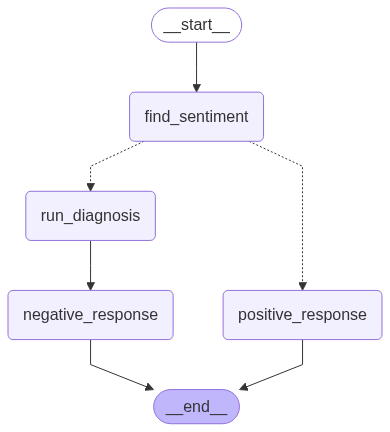

In [16]:
from IPython.display import Image
Image(filename="customer_review.png")

In [17]:
from langgraph.graph import StateGraph, START, END
# from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from typing import TypedDict, Literal
from pydantic import BaseModel, Field
import operator

In [18]:
load_dotenv()

True

In [19]:
# model=ChatGroq(model='llama-3.1-8b-instant')
model=ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [20]:
model.invoke('hy').content

'Hi there! How can I help you today?'

In [21]:
class ModelSchema1(BaseModel): 
    sentiment: Literal['Positive','Negetive']=Field(description='sentiment of the review')


class ModelSchema2(BaseModel): 
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')


In [22]:
structrured_model1=model.with_structured_output(ModelSchema1)
structrured_model2=model.with_structured_output(ModelSchema2)

In [23]:
class ReviewState(TypedDict): 
    review: str
    sentiment:Literal['Positive', 'Negetive']
    dignosis: dict
    response: str

In [24]:
def find_sentiment(state: ReviewState): 
    prompt=f"Find the sentiment for the given review \n {state['review']}"
    sentiment=structrured_model1.invoke(prompt).sentiment

    return {'sentiment': sentiment}

In [25]:
def cheak_condition(state: ReviewState)-> Literal['positive_response', 'run_dignosis']: 
    if state['sentiment']=='Positive': 
        return 'positive_response'
    else:  
        return 'run_dignosis'

In [26]:
def positive_response(state: ReviewState): 
    prompt = f"""Write a warm thank-you message in response to this review:
             \n\n\"{state['review']}\"\n
             Also, kindly ask the user to leave feedback on our website."""
    
    response=model.invoke(prompt).content
    return {'response': response}

In [27]:
def run_dignosis(state: ReviewState): 
    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
                    "Return issue_type, tone, and urgency.
                """
    response=structrured_model2.invoke(prompt) # pydantic object
    return {'dignosis': response.model_dump()}



In [28]:
def negetive_response(state: ReviewState): 
    dignosis = state['dignosis']

    prompt = f"""You are a support assistant.
                The user had a '{dignosis['issue_type']}' issue, sounded '{dignosis['tone']}', and marked urgency as '{dignosis['urgency']}'.
                Write an empathetic, helpful resolution message.
              """
    response = model.invoke(prompt).content

    return {'response': response}

In [29]:
graph=StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('negetive_response', negetive_response)
graph.add_node('run_dignosis', run_dignosis)

graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment', cheak_condition)
graph.add_edge('run_dignosis', 'negetive_response')
graph.add_edge('positive_response', END)
graph.add_edge('negetive_response', END)

workflow=graph.compile()

In [30]:
initial_state={'review': "I am very disappointed with this product. It stopped working properly within a few days, and the build quality feels very cheap. The features do not match what was advertised, and the customer service was unresponsive when I asked for help. Overall, a complete waste of money."}

workflow.invoke(initial_state)

{'review': 'I am very disappointed with this product. It stopped working properly within a few days, and the build quality feels very cheap. The features do not match what was advertised, and the customer service was unresponsive when I asked for help. Overall, a complete waste of money.',
 'sentiment': 'Negetive',
 'dignosis': {'issue_type': 'Bug', 'tone': 'disappointed', 'urgency': 'high'},
 'response': 'Subject: Good News: Your Urgent Bug Report Has Been Addressed!\n\nHi [User Name],\n\nI\'m genuinely sorry to hear about the bug you\'ve encountered, and I completely understand your disappointment and the high urgency you\'ve highlighted. We know how critical it is for things to work smoothly, and we truly appreciate you bringing this to our attention so promptly.\n\nOur team immediately escalated and investigated the issue you reported regarding [briefly mention the bug, e.g., "the data not saving correctly" or "the login failing"].\n\nI\'m pleased to confirm that a fix has been suc

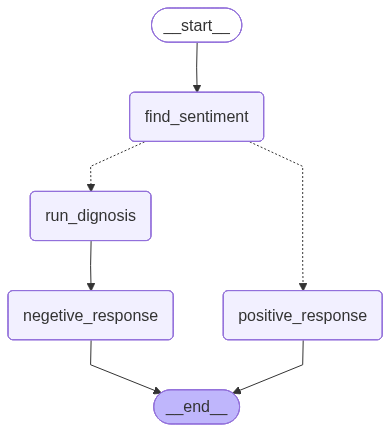

In [31]:
workflow